# Statistical analysis
Analyzing the data in a way that whatever conclusion we get is not subjective or due to change. We cast the question or hypothsis in a way to check that the sample/data supports the hypothesis.

We are going to study GPS time series in the Pacific Northwest and explore the long term motions due to the Cascadia subduction zone. We will download GPS time series from the University of Nevada - Reno, data center:
http://geodesy.unr.edu/NGLStationPages/gpsnetmap/GPSNetMap.html


In [80]:
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

sta="P395"
file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
r = requests.get(file_url).text.splitlines()  # download, read text, split lines into a list
ue=[];un=[];uv=[];se=[];sn=[];sv=[];date=[];date_year=[];df=[]
for iday in r:  # this loops through the days of data
    crap=iday.split()
    if len(crap)<10:
      continue
    date.append((crap[1]))
    date_year.append(float(crap[2]))
    ue.append(float(crap[6])*1000)
    un.append(float(crap[7])*1000)
    uv.append(float(crap[8])*1000)
#             # errors
    se.append(float(crap[10])*1000)
    sn.append(float(crap[11])*1000)
    sv.append(float(crap[12])*1000)

  # make dataframe
crap={'station':sta,'date':date,'date_year':date_year,'east':ue,'north':un,'up':uv}
if len(df)==0:
    df = pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])
else:
    df=pd.concat([df,pd.DataFrame(crap, columns = ['station', 'date','date_year','east','north','up'])])
df.describe()



,date_year,east,north,up
count,5538.000000,5538.000000,5538.000000,5538.000000
mean,2013.666802,-45.255712,-26.332619,1.321704
std,4.392001,28.100376,15.459581,5.347930
min,2006.067100,-96.287000,-56.580000,-39.508000
25%,2009.856975,-70.828750,-40.368500,-2.218000
50%,2013.666000,-43.663000,-26.110500,1.254500
75%,2017.477725,-22.284750,-12.925750,4.810250
max,2021.273100,3.927000,3.157000,27.475000


In [81]:
# Make a folium map of the station location

Text(0.5, 0, 'Time (years)')

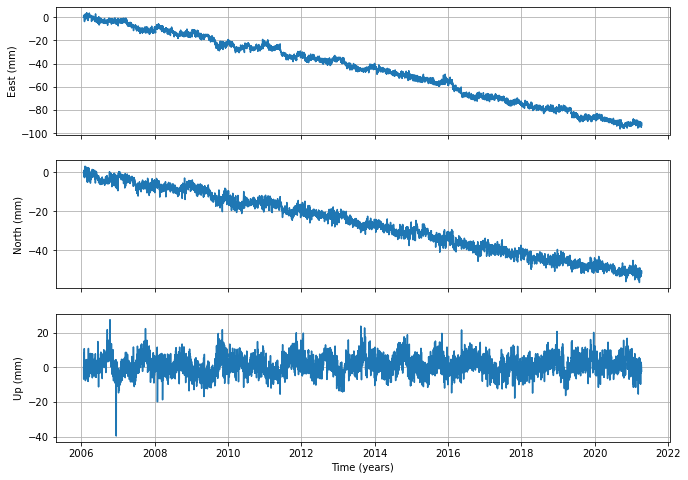

In [82]:
# Plot the GPS time series
fig,ax=plt.subplots(3,1,figsize=(11,8),sharex=True)
ax[0].plot(df['date_year'][df['station']==sta],df['east'][df['station']==sta]);ax[0].grid(True);ax[0].set_ylabel('East (mm)')
ax[1].plot(df['date_year'][df['station']==sta],df['north'][df['station']==sta]);ax[1].grid(True);ax[1].set_ylabel('North (mm)')
ax[2].plot(df['date_year'][df['station']==sta],df['up'][df['station']==sta]);ax[2].grid(True);ax[2].set_ylabel('Up (mm)')
ax[2].set_xlabel('Time (years)')

There is a clearn **linear trend** in the horizontal position data over the course of the past 16 years. Obviously we could fit the data as such:

$E(t) = V_e t + u_e,$\
$N(t) = V_n t + u_n,$

where $t$ is time, and we want to regress the data to find the coefficients $V_e$, $u_e$, $V_n$, $u_n$. The displacements are mostly westward, so we will just focus on the East $E(t)$ component for this exercise. The coefficients $u_e$ and $u_n$ are the intercept at $t=0$. They are not zero in this case because $t$ starts in 2006. The coefficients $V_e$ and $V_n$ have the dimension of velocities:

$V_e \sim E(t) / t$ , $V_n \sim N(t) / t$ ,

therefore, we will use this example to discuss a simple regression and resampling method. Linear regression is ultra basic, we will use both a Scipy function and a Scikit-learn function.

To measure a fit performance, we will measure how well the variance is reduced by fitting the data (scatter points) against the model. The variance is:

$\text{Var}(x) = 1/n \sum_{i=1}^n (x_i-\hat{x})^2$, 

where $\hat{x}$ is the mean of $x$.  When fitting the regression, we predict the values $x_{pred}$. The residuals are the differences between the data and the predicted values: $e = x - x_{pred} $. $R^2$ or <i> coefficient of determination</i> is:

$R^2 = 1 - \text{Var}(x-x_{pred}) /\text{Var}(x)  = 1 - \text{Var}(e) /\text{Var}(x) $
The smaller the error, the "better" the fit (we will discuss later that a fit can be too good!), the closter $R^2$ is to one.

In [121]:
# now let's find the trends and detrend the data.
from scipy import stats
# linear regression such that: displacement = Velocity * time
# velocity in the East componentone.
Ve, intercept, r_value, p_value, std_err = stats.linregress(df['date_year'][df['station']==sta],df['east'][df['station']==sta])
# horizontal plate motion:
print(sta,"overall plate motion there",Ve,'mm/year')
print("parameters: Coefficient of determination %f4.2, P-value %f4.2, standard deviation of errors %f4.2"\
      %(r_value,p_value,std_err))


P395 overall plate motion there -6.366768944494508 mm/year
parameters: Coefficient of determination -0.9951064.2, P-value 0.0000004.2, standard deviation of errors 0.0084974.2


Coefficient / Velocity eastward (mm/year):  -6.366768944494507


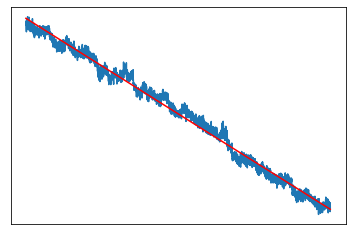

In [138]:
from sklearn.linear_model import LinearRegression
# convert the data into numpy arrays.
E = np.asarray(df['east'][df['station']==sta]).reshape(-1, 1)# reshaping was necessary to be an argument of Linear regress
t = np.asarray(df['date_year'][df['station']==sta]).reshape(-1, 1)
tt = np.linspace(np.min(t),np.max(t),1000)

# perform the linear regression. First we will use the entire available data
regr = LinearRegression()
# we will first perform the fit:
regr.fit(t,E)
# We will first predict the fit:
Epred=regr.predict(t) 

# The coefficients
print('Coefficient / Velocity eastward (mm/year): ', regr.coef_[0][0])

plt.plot(t,E);ax[0].grid(True);ax[0].set_ylabel('East (mm)')
plt.plot(t,Epred,color="red")
plt.grid(True)
plt.xticks(())
plt.yticks(())
plt.show()


Here we will measure some fitting performance.

In [139]:

from sklearn.metrics import mean_squared_error, r2_score
# The mean squared error
print('Mean squared error (mm): %.2f'
      % mean_squared_error(E, Epred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(E, Epred))

Mean squared error (mm): 7.71
Coefficient of determination: 0.99


# Resampling methods
This lectures will cover basic resampling methods.
We will evaluate the ability for resampling methods to evaluate model.
Resampling methods involve repeatedly drawing samples from a training set and re-fitting a model.
There are several tutorials on cross-validation: https://scikit-learn.org/stable/modules/cross_validation.html




## 1) Cross validation

Used to test error associated with a given statistical error and is used in model assessment.

<div>
<img src="grid_search_cross_validation.png" width="500"/>
</div>

training error can dramatically underestimate the test error because training tends to have more samples.

### a) Validation set approach

randomly divide the obseveration between a <i>training set</i> and a <i>validation set</i>.


<div>
<img src="ValsetApproach.png" width="500"/>
</div>

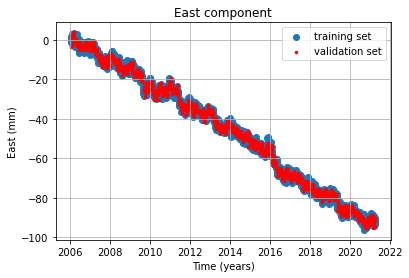

In [140]:
# we randomly select values and split the data between training and validation set.
from sklearn.model_selection import ShuffleSplit
# we split once the data between a training and a validating set 
n=1 # we do this selectio once
v_size = 0.3 # 30% of the data will be randomly selected to be the validation set.

rs = ShuffleSplit(n_splits=n, test_size=.3, random_state=0)
for train_index, val_index in rs.split(E):
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
plt.scatter(t_train,E_train,marker="o");plt.grid(True);plt.ylabel('East (mm)')
plt.scatter(t_val,E_val,marker="o",s=6,c="red")
plt.xlabel('Time (years)')
plt.title('East component')
plt.legend(['training set','validation set'])

Now fit the data and evaluate the error

Training set: Coefficient / Velocity eastward (mm/year):  -6.370542008628749
Validation set: Coefficient / Velocity eastward (mm/year):  -6.357638935167226
Mean squared error (mm): 0.02
Coefficient of determination: 1.00


Text(0.5, 1.0, 'Random selection for data split')

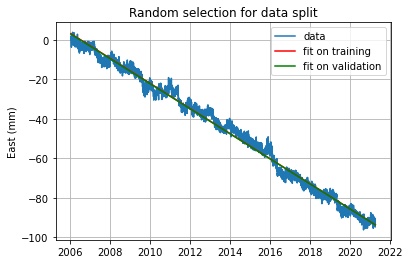

In [141]:
# now fit the data on the training set.
regr = LinearRegression()
regr_val = LinearRegression()
# Fit on training data:
regr.fit(t_train,E_train)
# Fit on validation data:
regr_val.fit(t_val,E_val)
# We will first predict the fit:
Epred=regr.predict(t) 
Epred_val=regr_val.predict(t) 

# The coefficients
print('Training set: Coefficient / Velocity eastward (mm/year): ', regr.coef_[0][0])
print('Validation set: Coefficient / Velocity eastward (mm/year): ', regr_val.coef_[0][0])

print('Mean squared error (mm): %.2f'
      % mean_squared_error(Epred, Epred_val))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Epred, Epred_val))

plt.plot(t,E);plt.grid(True);plt.ylabel('East (mm)')
plt.plot(t,Epred,color="red")
plt.plot(t,Epred_val,color="green")
plt.legend(['data','fit on training','fit on validation'])
plt.title('Random selection for data split')


(array([1., 2., 0., 2., 0., 0., 1., 0., 0., 2., 0., 1., 1., 1., 3., 1., 4.,
        6., 0., 3., 3., 2., 5., 4., 2., 6., 5., 4., 3., 6., 2., 2., 2., 4.,
        2., 2., 2., 3., 3., 1., 4., 1., 0., 1., 1., 1., 0., 0., 0., 1.]),
 array([-6.38663687, -6.38585283, -6.38506879, -6.38428474, -6.3835007 ,
        -6.38271666, -6.38193261, -6.38114857, -6.38036453, -6.37958048,
        -6.37879644, -6.3780124 , -6.37722835, -6.37644431, -6.37566027,
        -6.37487622, -6.37409218, -6.37330814, -6.37252409, -6.37174005,
        -6.37095601, -6.37017196, -6.36938792, -6.36860388, -6.36781983,
        -6.36703579, -6.36625175, -6.36546771, -6.36468366, -6.36389962,
        -6.36311558, -6.36233153, -6.36154749, -6.36076345, -6.3599794 ,
        -6.35919536, -6.35841132, -6.35762727, -6.35684323, -6.35605919,
        -6.35527514, -6.3544911 , -6.35370706, -6.35292301, -6.35213897,
        -6.35135493, -6.35057088, -6.34978684, -6.3490028 , -6.34821875,
        -6.34743471]),
 <BarContainer object

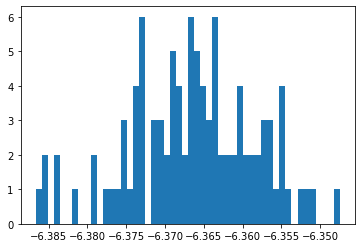

In [144]:
plt.hist(vel,bins=50)

We can also select the training and validation to be chronological. If the "state" of the data changes through time, this may induce a bias in the training. But let's see.

Training set: Coefficient / Velocity eastward (mm/year):  -5.800823719371802
Validation set: Coefficient / Velocity eastward (mm/year):  -5.937282574246366
Mean squared error (mm): 32.92
Coefficient of determination: 0.95


Text(0.5, 1.0, 'Chronological selection for data split')

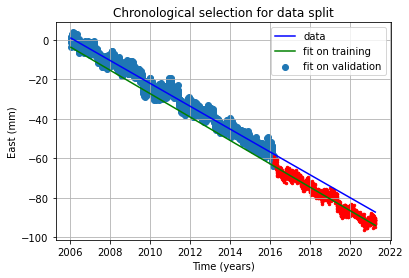

In [126]:
E_train, E_val = E[:2*len(E)//3], E[2*len(E)//3+1:]
t_train, t_val = t[:2*len(E)//3], t[2*len(E)//3+1:]
plt.scatter(t_train,E_train,marker="o");plt.grid(True);plt.ylabel('East (mm)')
plt.scatter(t_val,E_val,marker="o",s=6,c="red")
plt.xlabel('Time (years)')
plt.title('East component')
plt.legend(['training set','validation set'])

# now fit the data on the training set.
regr = LinearRegression()
regr_val = LinearRegression()
# Fit on training data:
regr.fit(t_train,E_train)
# Fit on validation data:
regr_val.fit(t_val,E_val)
# We will first predict the fit:
Epred=regr.predict(t) 
Epred_val=regr_val.predict(t) 

# The coefficients
print('Training set: Coefficient / Velocity eastward (mm/year): ', regr.coef_[0][0])
print('Validation set: Coefficient / Velocity eastward (mm/year): ', regr_val.coef_[0][0])

print('Mean squared error (mm): %.2f'
      % mean_squared_error(Epred, Epred_val))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Epred, Epred_val))

plt.plot(t,Epred,color="blue")
plt.plot(t,Epred_val,color="green")
plt.legend(['data','fit on training','fit on validation'])
plt.title('Chronological selection for data split')


### 2) Leave One Out Cross Validation

LOOCV splits the data in 2 sets (training and validation) <i>n</i> times (<i>n</i> is the number of data points). At each repeat, the training set is **all but one** data, the validation set is one element.

<div>
<img src="LOOCV.png" width="500"/>
</div>
Advantages: it has far less bias with respect to the training data. It does not overestimate the test error. Repeated LOOCV will give the exact same results.

Disadvantages: it is computationally intensive.

In [145]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

vel = np.zeros(len(E)) # initalize a vector to store the regression values
mse = np.zeros(len(E))
r2s = np.zeros(len(E))
i=0
for train, test in loo.split(E):    
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
    # now fit the data on the training set.
    regr = LinearRegression()
    regr_val = LinearRegression()
    # Fit on training data:
    regr.fit(t_train,E_train)
    # Fit on validation data:
    regr_val.fit(t_val,E_val)
    # We will first predict the fit:
    Epred=regr.predict(t) 
    Epred_val=regr_val.predict(t) 

    # The coefficients
    vel[i]= regr.coef_[0][0]
    mse[i]= mean_squared_error(Epred, Epred_val)
    r2s[i]=r2_score(Epred, Epred_val)
    i+=1

# the data shows cleary a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %f4.2 and the standard deviation %f4.2"%(np.mean(vel),np.std(vel)))
# the test error is the average of the mean-square-errors
print("CV = %f4.2"%(np.mean(mse)))

mean of the velocity estimates -6.3705424.2 and the standard deviation 0.0000004.2
CV = 0.0172194.2


### 2)K-fold cross validation

Designed to reduce the computational cost of LOOCV. Randomly devide over <i>k</i> groups/folds of approximately equal size. It is typical to use <i>5</i> or <i>10</i>.

<div>
<img src="Kfold.png" width="500"/>
</div>

In [128]:
from sklearn.model_selection import KFold
k=10
kf = KFold(n_splits=k)

vel = np.zeros(k) # initalize a vector to store the regression values
mse = np.zeros(k)
r2s = np.zeros(k)
i=0
for train, test in kf.split(E):    
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
    # now fit the data on the training set.
    regr = LinearRegression()
    regr_val = LinearRegression()
    # Fit on training data:
    regr.fit(t_train,E_train)
    # Fit on validation data:
    regr_val.fit(t_val,E_val)
    # We will first predict the fit:
    Epred=regr.predict(t) 
    Epred_val=regr_val.predict(t) 

    # The coefficients
    vel[i]= regr.coef_[0][0]
    mse[i]= mean_squared_error(Epred, Epred_val)
    r2s[i]=r2_score(Epred, Epred_val)
    i+=1

# the data shows cleary a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %f4.2 and the standard deviation %f4.2"%(np.mean(vel),np.std(vel)))
# the test error is the average of the mean-square-errors
print("CV = %f4.2"%(np.mean(mse)))

mean of the velocity estimates -6.3705424.2 and the standard deviation 0.0000004.2
CV = 0.0172194.2


## 2) Bootstrapping
Commonly used to provide a measure of accuracy of a parameter estimate or of a given statistical learning method. Random sampling **with replacement** cross-validation iterator. Contrary to cross-validation, bootstrapping allows some samples to occur several times in each splits. However a sample that occurs in the train split will never occur in the test split and vice-versa.
For linear regression fit, standard errors are automatically calculated in regression toolbox. But if the model is more complicated, bootstrapping provides one way to calculate these errors.

Scikit-learn seems to have deprecated the bootstrap function, but we can find ``resample`` in the ``utils`` module. Make sure you use ``replace=True``.
For reproducible results, you can select a fixed ``random_state=int`` to be kept in the workflow. Usually bootstrapping is done over many times (unlike K-fold cross validation).

In [136]:
from sklearn.utils import resample
k=100
vel = np.zeros(k) # initalize a vector to store the regression values
mse = np.zeros(k)
r2s = np.zeros(k)
i=0
for iik in range(k):    
    ii = resample(np.arange(len(E)),replace=True,n_samples=len(E))# new indices
    E_b, t_b = E[ii], t[ii]
    # now fit the data on the training set.
    regr = LinearRegression()
    regr_val = LinearRegression()
    # Fit on training data:
    regr.fit(t_b,E_b)
    Epred=regr.predict(t) 

    # The coefficients
    vel[i]= regr.coef_[0][0]
    i+=1

# the data shows cleary a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %f4.2 and the standard deviation %f4.2"%(np.mean(vel),np.std(vel)))


mean of the velocity estimates -6.3664604.2 and the standard deviation 0.0081714.2


(array([ 5.,  3.,  6., 14., 16., 24., 12., 11.,  7.,  2.]),
 array([-6.38663687, -6.38271666, -6.37879644, -6.37487622, -6.37095601,
        -6.36703579, -6.36311558, -6.35919536, -6.35527514, -6.35135493,
        -6.34743471]),
 <BarContainer object of 10 artists>)

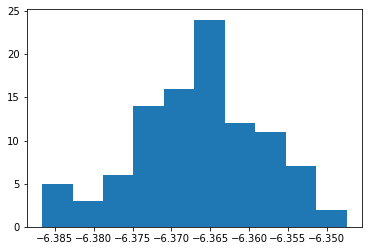

In [137]:
plt.hist(vel)